The dataset is all TR data


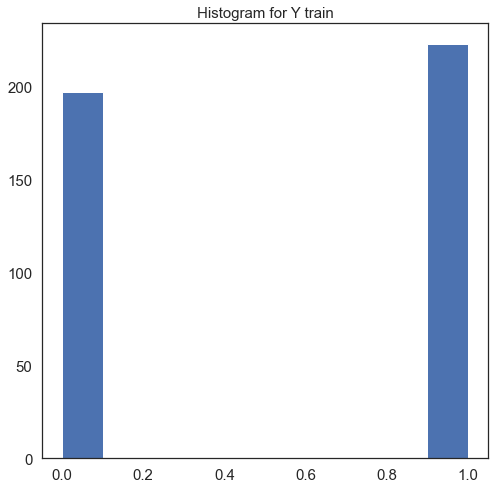

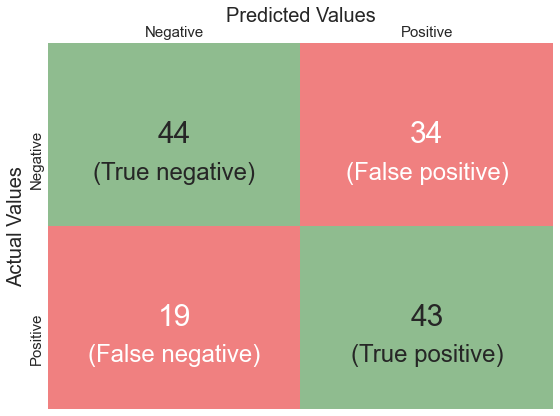

Accuracy train: 58.09523809523809
Accuracy test: 62.142857142857146
Sensitivity: The 69.84126984126983 were correctly identified as not having an ictus
Specificity: The 55.84415584415584 were correctly identified as having an ictus
 
 


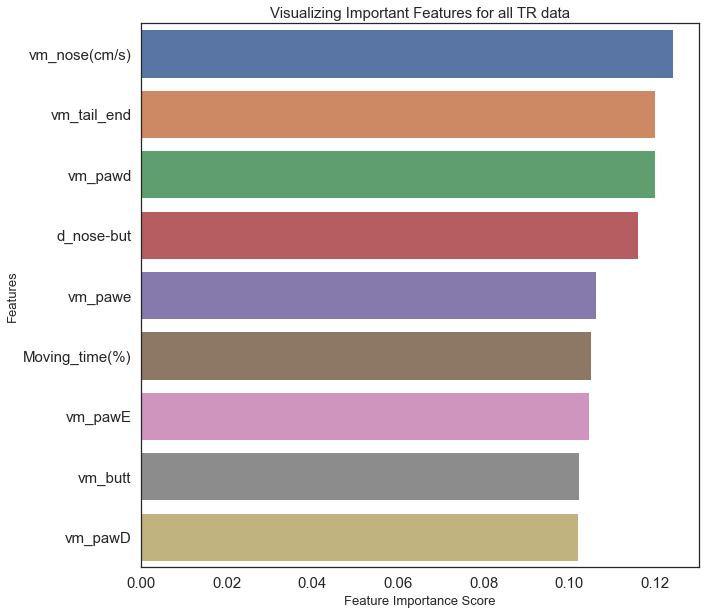

Accuracy of mice:  72.0
 
The dataset is all POST data


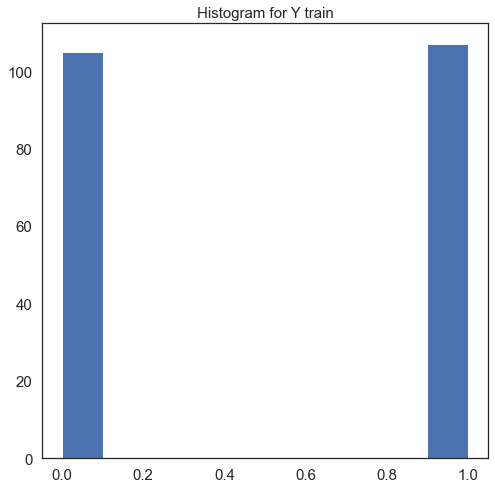

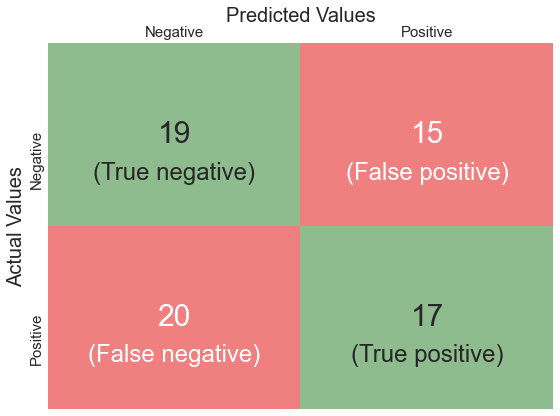

Accuracy train: 69.81132075471699
Accuracy test: 50.70422535211267
Sensitivity: The 48.717948717948715 were correctly identified as not having an ictus
Specificity: The 53.125 were correctly identified as having an ictus
 
 


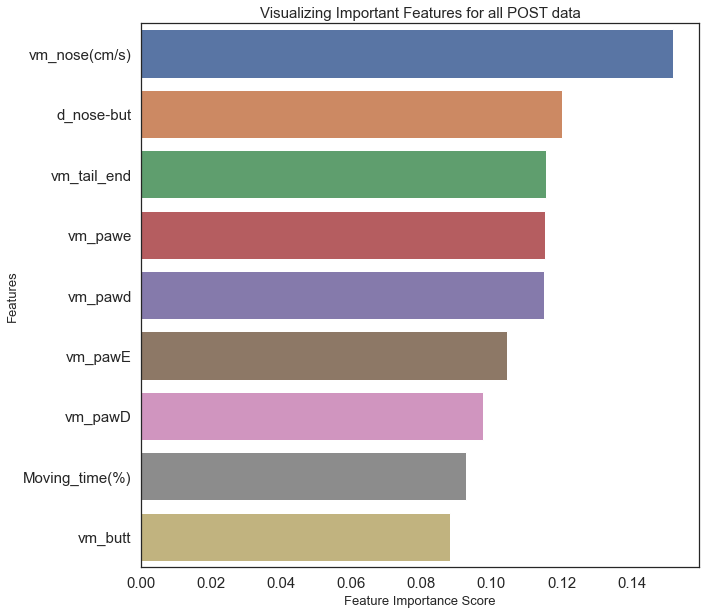

Accuracy of mice:  46.15384615384615
 
The dataset is PRE data


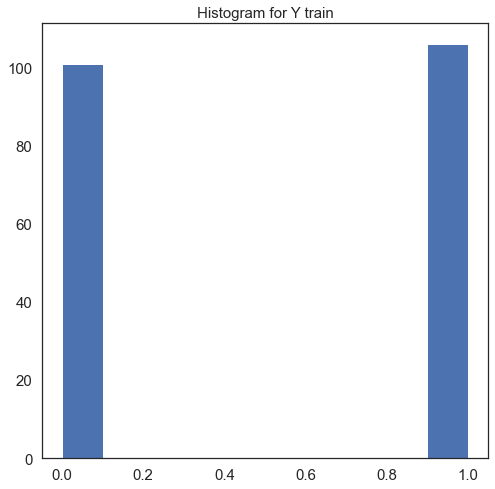

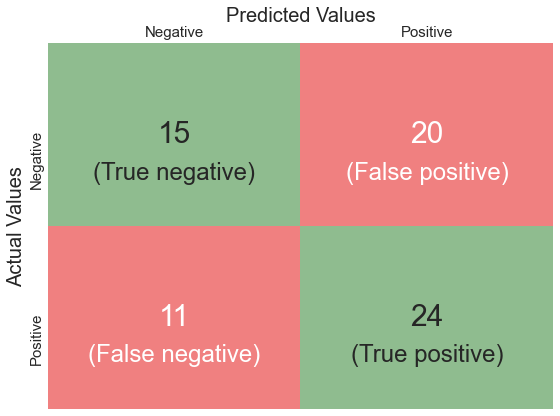

Accuracy train: 46.88914027149321
Accuracy test: 55.714285714285715
Sensitivity: The 57.692307692307686 were correctly identified as not having an ictus
Specificity: The 54.54545454545454 were correctly identified as having an ictus
 
 


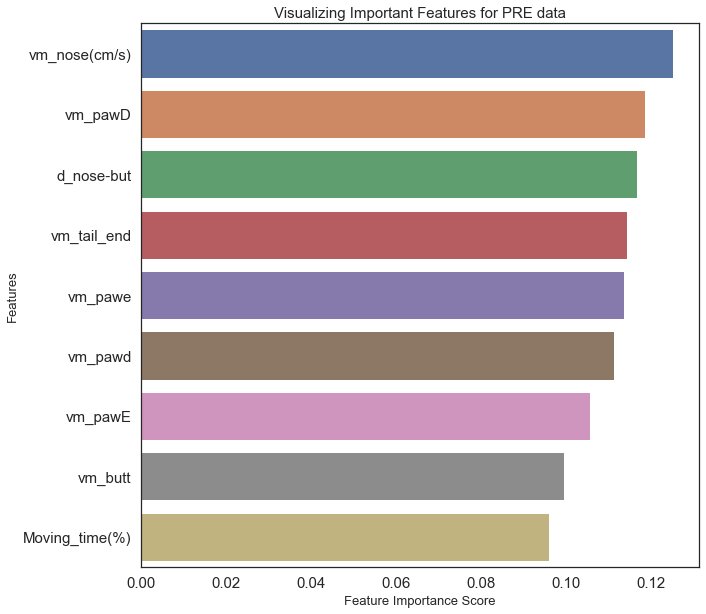

Accuracy of mice:  48.0
 
The dataset is POST 24H data


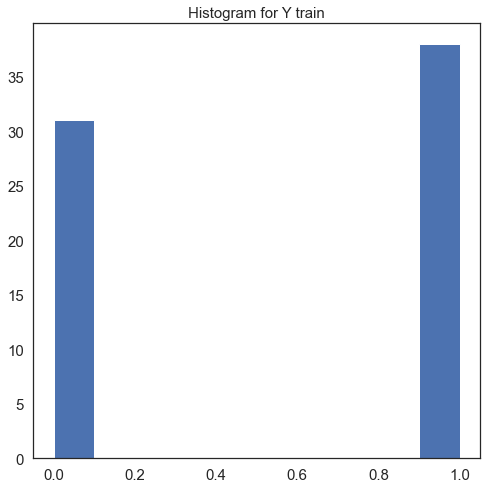

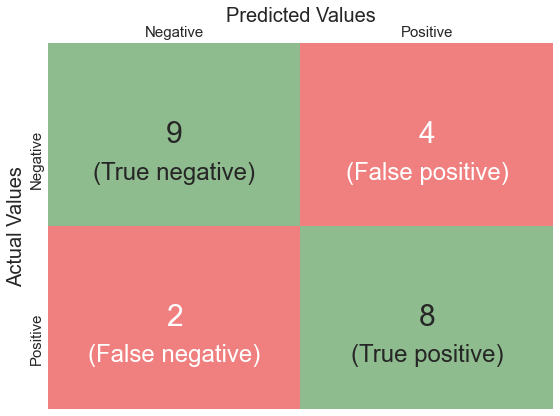

Accuracy train: 58.74183006535948
Accuracy test: 73.91304347826086
Sensitivity: The 81.81818181818183 were correctly identified as not having an ictus
Specificity: The 66.66666666666666 were correctly identified as having an ictus
 
 


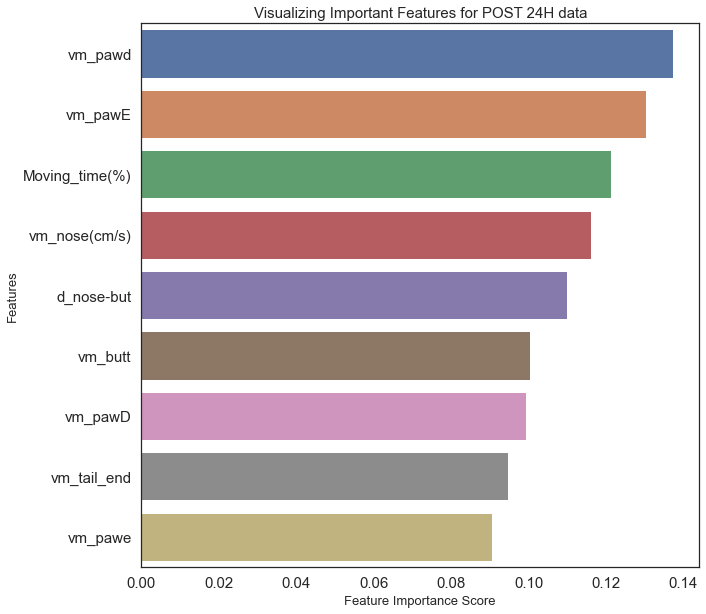

Accuracy of mice:  64.70588235294117
 
The dataset is POST 48H data


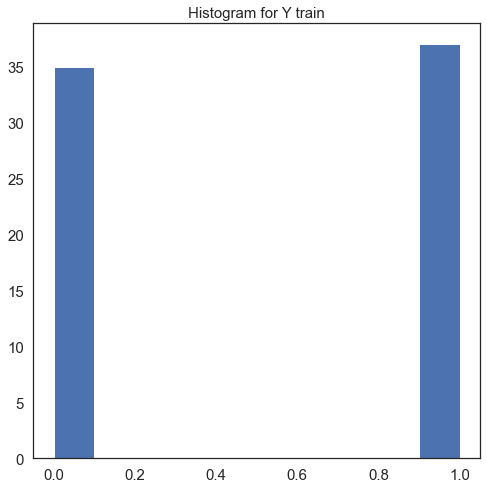

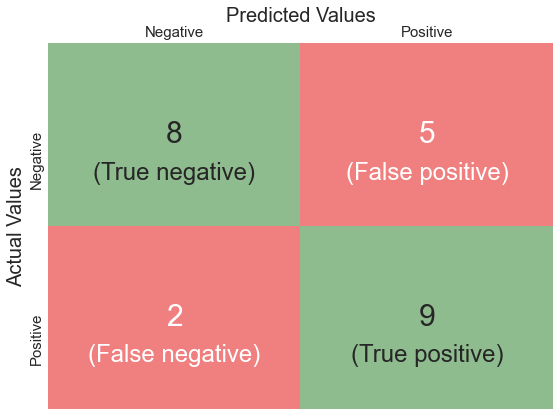

Accuracy train: 62.5
Accuracy test: 70.83333333333334
Sensitivity: The 80.0 were correctly identified as not having an ictus
Specificity: The 64.28571428571429 were correctly identified as having an ictus
 
 


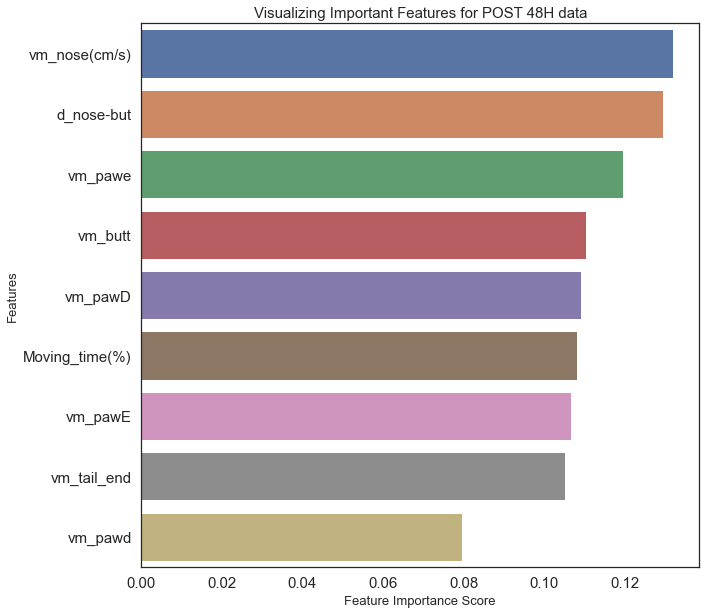

Accuracy of mice:  63.1578947368421
 
The dataset is POST 72H data


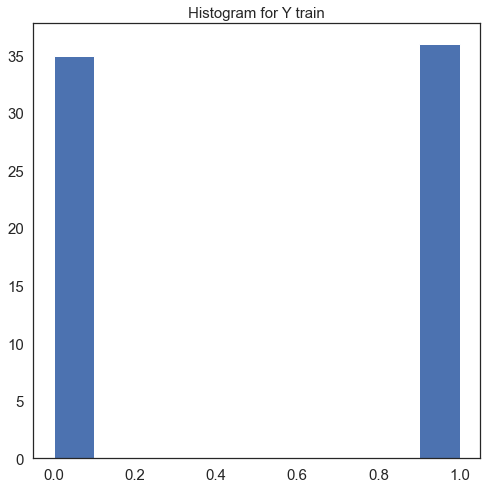

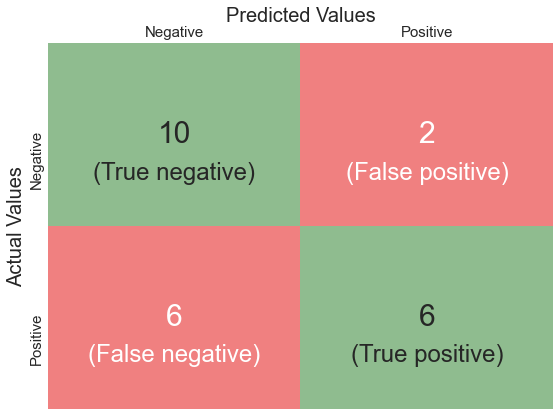

Accuracy train: 71.85457516339869
Accuracy test: 66.66666666666666
Sensitivity: The 62.5 were correctly identified as not having an ictus
Specificity: The 75.0 were correctly identified as having an ictus
 
 


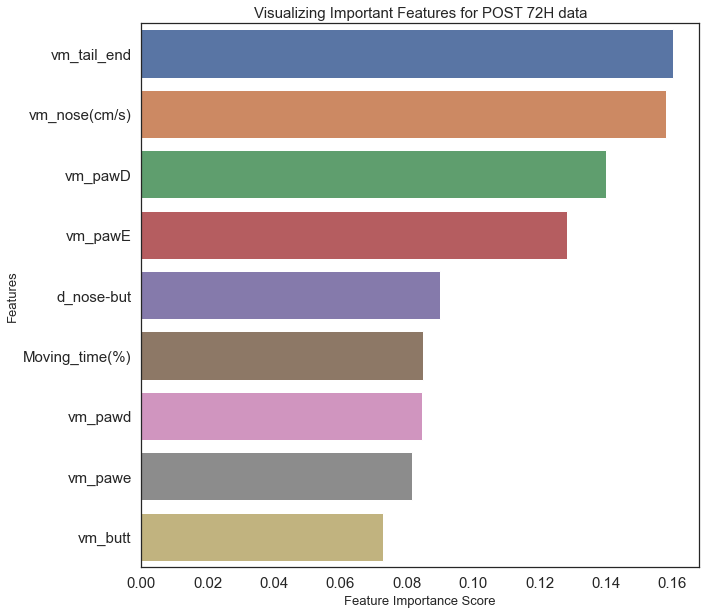

Accuracy of mice:  55.55555555555556
 
The dataset is POST 48H & 72H


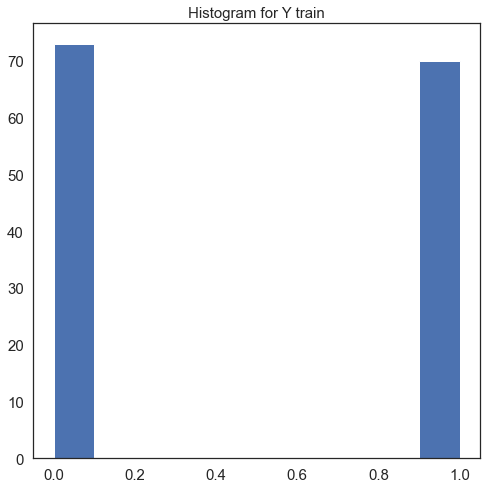

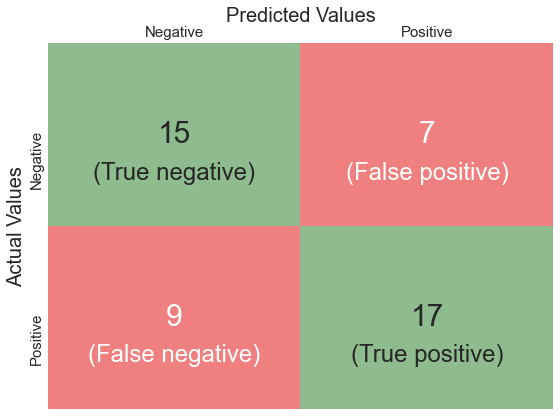

Accuracy train: 64.65277777777777
Accuracy test: 66.66666666666666
Sensitivity: The 62.5 were correctly identified as not having an ictus
Specificity: The 70.83333333333334 were correctly identified as having an ictus
 
 


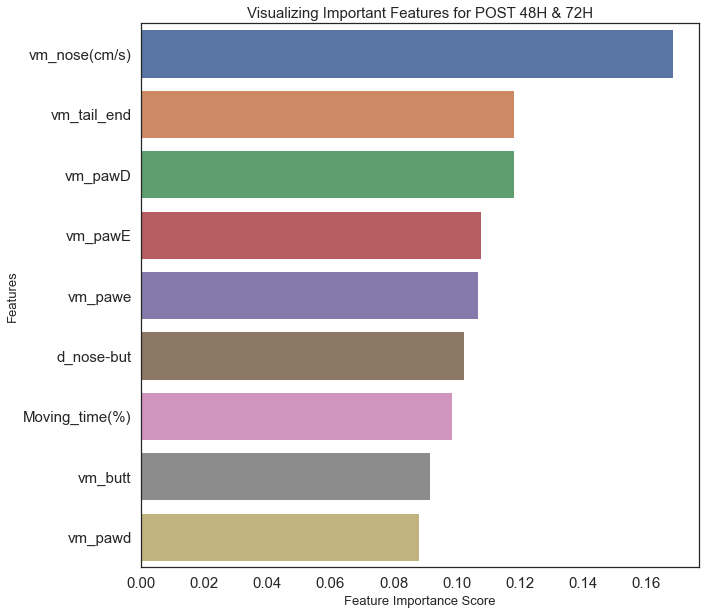

Accuracy of mice:  52.17391304347826
 


In [6]:
# 
#         COMBIO PROJECT: DATA ANALISIS
#         Marta Alcalde & Núria Mercadé     
# 
# ===========================================================================
#           PREDICCTION MODELS - RANDOM FOREST REGRESSION
# ===========================================================================

# This prediction includes a mice-based prediction. It works by reading whether 
# videos of the same mice were predicted to have or not have stroke, and if
# the prediciton does not match with the majority of videos output predicitons,
# it is changed. 
# Moreover, only specific data from data analysis is taken into account.

from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import RepeatedStratifiedKFold,StratifiedKFold
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import confusion_matrix,roc_curve,roc_auc_score
from sklearn.ensemble              import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.linear_model          import LogisticRegression
from sklearn.metrics               import RocCurveDisplay
from sklearn.preprocessing         import StandardScaler
from sklearn                       import metrics
#from sklearn.tree                  import DecisionTreeClassifier
#from sklearn.neighbors             import KNeighborsClassifier
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import os

# Set seed
#seed = 100
seed = 90

# Read Excel
#file = "C:/Users/Marta/Dropbox/COMBIO/dades.xlsx"
file = "/Users/nmercade/Desktop/dades.xlsx"

data_dirty   = pd.read_excel(file,header = 0, usecols = "A,B,H:AD")
# Non coherent data
data = data_dirty.drop([0,1,118,219,342,445])
mydataTR = {0: data.loc[(data["Test"] == "TR - POST - 24H") | (data["Test"] == "TR - POST - 48H") |\
                  (data["Test"] == "TR - POST - 72H") | (data["Test"] == "TR - PRE")],\
         1: data.loc[(data["Test"] == "TR - POST - 24H") | (data["Test"] == "TR - POST - 48H") |\
                  (data["Test"] == "TR - POST - 72H")],\
         2: data.loc[(data["Test"] == "TR - PRE")], 3: data.loc[(data["Test"] == "TR - POST - 24H")],\
         4: data.loc[(data["Test"] == "TR - POST - 48H")], 5: data.loc[(data["Test"] == "TR - POST - 72H")],\
         6: data.loc[(data["Test"] == "TR - POST - 48H") | (data["Test"] == "TR - POST - 72H")]}
datTR = {0: 'all TR data', 1: 'all POST data', 2: 'PRE data', 3: 'POST 24H data', 4: 'POST 48H data', 5: 'POST 72H data', 6: 'POST 48H & 72H'}

for jj in range(7):
    data = mydataTR[jj];
    print('The dataset is {}'.format(datTR[jj]))
    # Define predictor and response variables
    # 1. Response variable:
        # 0: Not having an ictus
        # 1: Having an ictus
    inf = np.array(data["% Infarct"].dropna()); y = [];
    for i in range(len(inf)):
        if inf[i] > 0:
            y.append(1)
        else:
            y.append(0)
    y = np.array(y)

    # 2. Independent variables
    x = data.loc[:,"Moving_time(%)":"vm_pawd"].join(data.loc[:,"d_nose-but"])
    

    # Creation of two datasets: test and train
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(x,y,test_size = 0.25, random_state = seed)

    # Scale the data
    sc = StandardScaler()
    XtrainN = sc.fit_transform(Xtrain)
    XtestN  = sc.transform(Xtest)

    # Visualization of the response variable to prove if it is balanced.
    plt.figure(figsize=(8,8))
    plt.hist(Ytrain)
    plt.tick_params(labelsize = 15)
    plt.title('Histogram for Y train', fontsize=15)    
    path = './RF/H_{}'.format(jj)
    plt.savefig(path)

    # Training of the data
    model = RandomForestClassifier(n_estimators=1000, max_features='log2')
    model.fit(XtrainN,Ytrain)
    Ypred = model.predict(XtestN)
    
    # KFold method
    cv = RepeatedStratifiedKFold(n_splits = 4, n_repeats = 2, random_state = seed)
    #cv = StratifiedKFold(n_splits = 10)
    # Evaluate model 
    scores = cross_val_score(model, Xtrain, Ytrain, scoring = 'accuracy', cv = cv)
    Ypred = model.predict(XtestN)
    
    # Confusion matrix
    cm = confusion_matrix(Ytest,Ypred)
    sns.set(style = 'white')
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(np.eye(2), annot = cm, fmt = 'g', annot_kws = {'size': 30},
                cmap = sns.color_palette(['lightcoral', 'darkseagreen'], as_cmap=True), cbar=False,
                yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'], ax=ax)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(labelsize=19, length = 0)
    ax.set_xlabel('Predicted Values', size = 20)
    ax.set_ylabel('Actual Values', size = 20)
    additional_texts = ['(True negative)', '(False positive)', '(False negative)', '(True positive)']
    for text_elt, additional_text in zip(ax.texts, additional_texts):
        ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
                ha='center', va='top', size=24)
    plt.tight_layout()
    plt.tick_params(labelsize = 15)
    plt.show() 
    path = './RF/CM_{}'.format(jj)
    fig.savefig(path)

    # Test accuracy
    acc = (cm[0,0]+cm[1,1])/sum(sum(cm))*100
    print('Accuracy train: {}'.format(np.mean(scores)*100))
    print('Accuracy test: {}'.format(acc))
    # Sensitivity
    sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])*100
    print('Sensitivity: The {} were correctly identified as not having an ictus'.format(sensitivity))
    # Specificity
    specificity = cm[1,1]/(cm[1,1]+cm[0,1])*100
    print('Specificity: The {} were correctly identified as having an ictus'.format(specificity))
    print(' ')
    
    # Visualize the importance of each value in the model
    x_imp = pd.Series(model.feature_importances_,index=x.columns).sort_values(ascending=False)
    print(' ')
    %matplotlib inline
    figu = plt.figure(figsize=(10,10))
    # Creating a bar plot
    sns.barplot(x=x_imp, y=x_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score',fontsize=13)
    plt.ylabel('Features',fontsize=13)
    plt.title("Visualizing Important Features for {}".format(datTR[jj]),fontsize=15)
    plt.tick_params(labelsize = 15)
    plt.show()
    path = './RF/IM_{}'.format(jj)
    figu.savefig(path)  
    
    # =========================================================================
    # MICE ACCURACY
    # =========================================================================
    # Read the identification of the rat
    rat = pd.read_excel(file,header = 0, usecols = "A,B,H:AD");
    rat = rat.Mouse;
    # Select those identifications that are from the test part
    ratTest  = rat.iloc[Xtest.index];
    # Vector that contains each identification of the rat ones.
    lrt = list(set(ratTest));

    #convert each Series to a DataFrame (it is easier to operate with them)
    rt_df = ratTest.to_frame(name = 'Id');
    yp_df = pd.DataFrame(Ypred, columns = ['Pred']); yp_df.index = Xtest.index;
    yt_df = pd.DataFrame(Ytest, columns = ['Test']); yt_df.index = Xtest.index;

    Rpred = []; Rtest = [];
    ix1 = 0;
    
    # Loop to gather predictions and identification of the rat
    for ix in lrt:
        # Prediction
        pos = yp_df[ratTest == lrt[ix1]]
        ones = (pos.values == 1).sum()
        zero = (pos.values == 0).sum()
        
        if ones > zero:
            Rpred.append(1)
        if ones < zero:
            Rpred.append(0)
        if ones == zero:
            Rpred.append(2)
        
        # Test data
        pos = yt_df[ratTest == lrt[ix1]]
        ones = (pos.values == 1).sum()
        if ones >= 1:
            Rtest.append(1)
        else:
            Rtest.append(0)

        ix1 = ix1 + 1
    
    # Accuracy of rat
    cm = confusion_matrix(Rtest,Rpred)
    # Test accuracy 
    acc = (cm[0,0]+cm[1,1])/sum(sum(cm))*100       
    
    print('Accuracy of mice: ', acc)
    print(' ')    